# Deep Learning - Exercise 2
# 🧠 Collaborative Filtering with Gradient Descent
### Implementing Matrix Factorization from Scratch

## 📘 Introduction

Recommender systems are one of the most practical applications of machine learning — they power movie recommendations on Netflix, product suggestions on Amazon, and playlist generation on Spotify.  
A key technique behind many of these systems is **collaborative filtering**.

---

### 🎯 The Idea

Collaborative filtering assumes that similar users tend to like similar items.  
Instead of explicitly learning about the *content* (e.g., the genre of a movie), we use **patterns in user–item interactions** (like ratings or clicks) to make predictions.

We start with a matrix of ratings:

| User | Item 1 | Item 2 | Item 3 | Item 4 |
|------|--------|--------|--------|--------|
| A    | 5      | 3      | ?      | 1      |
| B    | 4      | ?      | ?      | 1      |
| C    | 1      | 1      | ?      | 5      |
| D    | ?      | ?      | 5      | 4      |

Our goal is to **predict the missing values** (the `?` entries).

---

### ⚙️ The Model

We assume each user and each item can be represented by a vector of hidden “features” (called **latent factors**).  
For example, in a movie dataset, latent factors might represent things like *action vs. drama*, *comedy*, or *romantic themes*.

We learn two matrices:

- $P$: user feature matrix (users × k)
- $Q$: item feature matrix (items × k)

Their product approximates the rating matrix:

$$
\hat{R} = P Q^T
$$

---

### 📉 The Optimization Problem

We want to find $P$ and $Q$ that minimize the difference between the known ratings and the predicted ones:

$$
\min_{P, Q} \sum_{(u, i) \in \Omega} (R_{ui} - P_u^T Q_i)^2
$$

where $\Omega$ is the set of known ratings.

We’ll solve this minimization using **gradient descent** — iteratively updating $P$ and $Q$ to reduce the total error.

---

### 🚀 Goal of This Exercise

By the end of this notebook, you will:
- Understand how collaborative filtering works mathematically.  
- Implement it **from scratch using NumPy**.  
- Train a small recommender model using **gradient descent**.  
- Visualize how the loss decreases during training.  

This will give you a deep understanding of how modern recommender systems (like Matrix Factorization in Netflix or implicit-feedback models) are built at their core.

## 📤 How to Submit
Submit **only** this notebook including your code in it, through the course system. Look for "# Your code here" for the places you need to add your code to the solution.


# Implementation

In [1]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# The data

Download movie ratings data:

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
# # Unzip it
!unzip ml-100k.zip
# # Get rid of the .zip file
!rm ml-100k.zip

--2025-11-29 10:19:22--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.grouplens.org/datasets/movielens/ml-100k.zip [following]
--2025-11-29 10:19:23--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  11.9MB/s    in 0.4s    

2025-11-29 10:19:23 (11.9 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml

In [3]:
ratings = pd.read_csv(
    "ml-100k/u.data",
    sep="\t", # this is a tab separated data
    names=["user_id", "movie_id", "rating", "timestamp"], # the columns names
    usecols=["user_id", "movie_id", "rating"], # we do not need the timestamp column
    low_memory=False
)
ratings

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


Split to train and test sets:

In [4]:
test_perc = 0.2

# Initialize the train and test dataframes.
train_set, test_set = pd.DataFrame(), pd.DataFrame()

# Check each user.
for user_id in ratings.user_id.unique():
    user_df = ratings[ratings.user_id == user_id].sample(
        frac=1,
        random_state=42
    ) # select only samples of the actual user and shuffle the resulting dataframe

    n_entries = len(user_df)
    n_test = int(round(test_perc * n_entries))

    test_set = pd.concat((test_set, user_df.tail(n_test)))
    train_set = pd.concat((train_set, user_df.head(n_entries - n_test)))

train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)

train_set.shape, test_set.shape

((80000, 3), (20000, 3))

Compute the dimensions of the matrix/problem:

In [5]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
n_users, n_movies

(943, 1682)

# Computing the function (hypothesis)

In [6]:
class H:
  def __init__(self, n, m, r):

    # Xavier initialization:
    self.P = np.random.randn(n, r) * np.sqrt(1/r)
    self.Q = np.random.randn(m, r) * np.sqrt(1/r)

  def predict(self):
    return self.P @ self.Q.T


# The error function

Implement squared error

In [7]:
def mse(ratings, R_hat):
  total_error = 0.0

  for i, row in ratings.iterrows():
    ui, mi, r = row.user_id, row.movie_id, row.rating
    total_error += (r - R_hat[ui - 1, mi - 1]) ** 2  # ids starts with 1

  return total_error / len(ratings)

In [8]:
h = H(n_users, n_movies, 5)
mse(train_set, h.predict())

np.float64(13.930206068238308)

# Training

### Computing the gradient

In [9]:
import sympy as sp

n = 3
a = sp.Symbol('a')

x = sp.Matrix(sp.symbols(f'x0:{n}'))
y = sp.Matrix(sp.symbols(f'y0:{n}'))

f = (x.dot(y) - a)**2

grad_x = sp.Matrix([sp.diff(f, xi) for xi in x])
grad_y = sp.Matrix([sp.diff(f, yi) for yi in y])

print("∇x f =")
sp.pprint(grad_x)
print("\n∇y f =")
sp.pprint(grad_y)

∇x f =
⎡2⋅y₀⋅(-a + x₀⋅y₀ + x₁⋅y₁ + x₂⋅y₂)⎤
⎢                                 ⎥
⎢2⋅y₁⋅(-a + x₀⋅y₀ + x₁⋅y₁ + x₂⋅y₂)⎥
⎢                                 ⎥
⎣2⋅y₂⋅(-a + x₀⋅y₀ + x₁⋅y₁ + x₂⋅y₂)⎦

∇y f =
⎡2⋅x₀⋅(-a + x₀⋅y₀ + x₁⋅y₁ + x₂⋅y₂)⎤
⎢                                 ⎥
⎢2⋅x₁⋅(-a + x₀⋅y₀ + x₁⋅y₁ + x₂⋅y₂)⎥
⎢                                 ⎥
⎣2⋅x₂⋅(-a + x₀⋅y₀ + x₁⋅y₁ + x₂⋅y₂)⎦


In [10]:
import sympy as sp

x, y, a = sp.symbols('x y a', real=True)

f = (x * y - a)**2

grad_x = sp.diff(f, x)
grad_y = sp.diff(f, y)

sp.pprint(grad_x)
sp.pprint(grad_y)

2⋅y⋅(-a + x⋅y)
2⋅x⋅(-a + x⋅y)


In [11]:
def update_gradient(h, ratings, lr):

  for i, row in ratings.iterrows():
    ui, mi, r = row.user_id, row.movie_id, row.rating
    pred = np.dot(h.P[ui-1], h.Q[mi-1])
    error = pred - r

    # compute gradient
    grad_P = 2 * error * h.Q[mi-1]
    grad_Q = 2 * error * h.P[ui-1]

    # update gradient
    h.P[ui-1] = h.P[ui-1] - lr * grad_P
    h.Q[mi-1] = h.Q[mi-1] - lr * grad_Q


### The algorithm - gradient descent

In [12]:
epochs = 100
lr = 0.001

In [13]:
# Your code here
from tqdm import tqdm

train_losses = []
test_losses = []

progress_bar = tqdm(range(epochs), total=epochs, desc=f"Training")
for epoch in progress_bar:
  update_gradient(h, train_set, lr)
  R_hat = h.predict()

  train_loss = mse(train_set, R_hat)
  test_loss = mse(test_set, R_hat)

  train_losses.append(train_loss)
  test_losses.append(test_loss)

  progress_bar.set_postfix({
      "train_loss": f"{train_loss:.4f}",
      "test_loss": f"{test_loss:.4f}",
  })


Training: 100%|██████████| 100/100 [13:50<00:00,  8.31s/it, train_loss=0.6931, test_loss=0.9370]


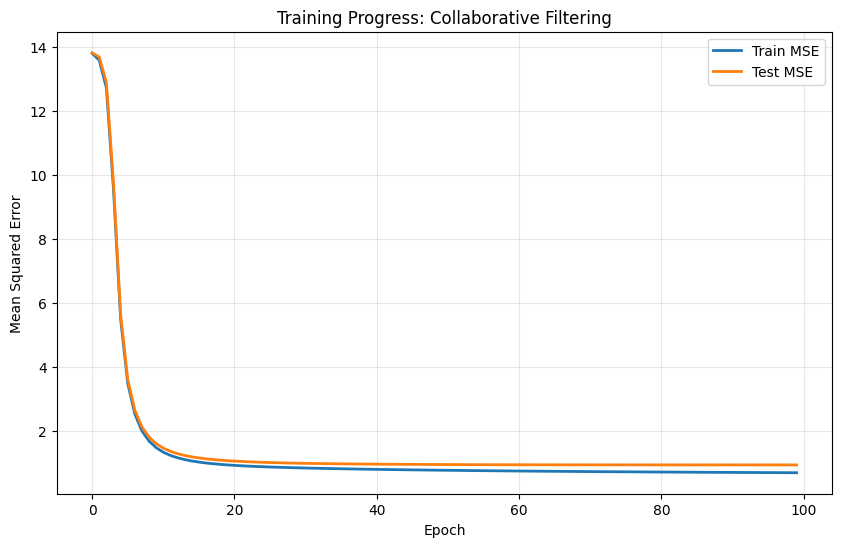


Final Train MSE: 0.6931
Final Test MSE: 0.9370


In [21]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train MSE', linewidth=2)
plt.plot(test_losses, label='Test MSE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Progress: Collaborative Filtering')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal Train MSE: {train_losses[-1]:.4f}")
print(f"Final Test MSE: {test_losses[-1]:.4f}")

# Testing

In [14]:
# Test with the test set
mse(test_set, h.predict())

np.float64(0.93702161680543)

In [15]:
s = []
for _, user_id, movie_id, rating in test_set.itertuples():
  s.append(abs(round(h.predict()[user_id-1, movie_id-1]) - rating))

In [16]:
S = pd.Series(s)
S.describe()

,0
count,20000.00000
mean,0.71470
std,0.71668
min,0.00000
25%,0.00000
50%,1.00000
75%,1.00000
max,5.00000


<Axes: ylabel='Frequency'>

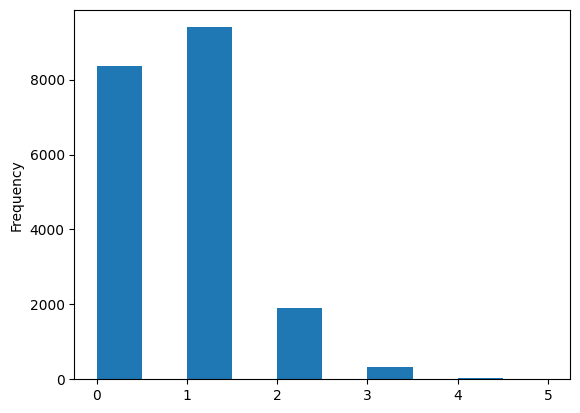

In [17]:
S.plot(kind='hist', bins=10)

In [18]:
S.value_counts()

,count
1,9398
0,8354
2,1890
3,323
4,28
5,7


In [19]:
# The different values in round(h.predict())
np.unique(np.round(h.predict()))

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.])

# Movies properties

If you want to dive deeper...

In [ ]:
import pandas as pd

# Column names as given by MovieLens
columns = [
    "movie_id", "title", "release_date", "video_release_date", "IMDb_URL",
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
    "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
    "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

# Read u.item
df_items = pd.read_csv(
    "ml-100k/u.item",
    sep="|",
    names=columns,
    encoding="ISO-8859-1"
)

print(df_items.head())

   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children's  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1           1  ...        0          0       0        0